# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

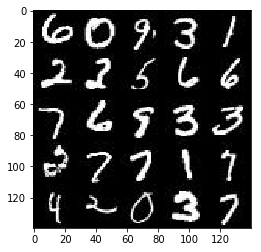

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

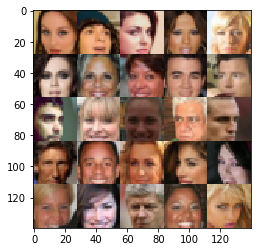

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(dtype=tf.float32, shape=(None, z_dim), name='z_input')
    lr_rate =  tf.placeholder(dtype=tf.float32, shape=(None), name='lr_rate')
    return real_input, z_input, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
            alpha = 0.01
            # Input layer is 32x32x3
            x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)

            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)

            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)

            flat = tf.reshape(relu3, (-1, 4*4*256))
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        dense1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        dense1 = tf.reshape(dense1,(-1, 2, 2, 512))
        
        batch_norm = tf.layers.batch_normalization(dense1, training=is_train)
        leakyrelu = tf.maximum(alpha * batch_norm, batch_norm)
              
        # Conv01
        conv01 = tf.layers.conv2d_transpose(leakyrelu, 256, 5, strides=2, padding='valid')
        conv01 = tf.layers.batch_normalization(conv01, training=is_train)
        conv01 = tf.maximum(alpha * conv01, conv01)
        
        #Conv2
        conv02 = tf.layers.conv2d_transpose(conv01, 128, 5, strides=2, padding='same')
        conv02 = tf.layers.batch_normalization(conv02, training=is_train)
        conv02 = tf.maximum(alpha * conv02, conv02)
               
        # Output layer
        logits = tf.layers.conv2d_transpose(conv02, out_channel_dim, 5, strides=2, padding='same')
               
        out = tf.tanh(logits)
        
    return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    all_trainable_vars = tf.trainable_variables()
    d_vars = [var for var in all_trainable_vars if var.name.startswith('discriminator')] 
    g_vars = [var for var in all_trainable_vars if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    _ , img_w, img_h, img_d = data_shape
    print("shape:",img_w,img_h,img_d)
    
    # Place holders for inputs
    input_real, input_z, lr = model_inputs(img_w, img_h, img_d, z_dim)
 
    # loss functions
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    
    
    # optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    losses = []
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Random noise for Generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images*2.0
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    #print(batch_images.shape)
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                         " Iter: {}".format(steps))
                
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, img_d, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

shape: 28 28 1
Epoch 1/2... Discriminator Loss: 0.3502... Generator Loss: 20.7733  Iter: 10
Epoch 1/2... Discriminator Loss: 3.5152... Generator Loss: 15.1621  Iter: 20
Epoch 1/2... Discriminator Loss: 2.7872... Generator Loss: 0.0874  Iter: 30
Epoch 1/2... Discriminator Loss: 1.5514... Generator Loss: 0.3753  Iter: 40
Epoch 1/2... Discriminator Loss: 1.5148... Generator Loss: 0.3997  Iter: 50
Epoch 1/2... Discriminator Loss: 0.3124... Generator Loss: 1.6324  Iter: 60
Epoch 1/2... Discriminator Loss: 0.6440... Generator Loss: 2.0347  Iter: 70
Epoch 1/2... Discriminator Loss: 0.8750... Generator Loss: 5.0796  Iter: 80
Epoch 1/2... Discriminator Loss: 0.4444... Generator Loss: 2.6153  Iter: 90
Epoch 1/2... Discriminator Loss: 1.4056... Generator Loss: 3.2287  Iter: 100


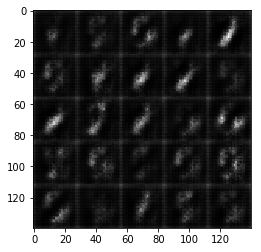

Epoch 1/2... Discriminator Loss: 1.2892... Generator Loss: 2.4844  Iter: 110
Epoch 1/2... Discriminator Loss: 1.2063... Generator Loss: 0.7822  Iter: 120
Epoch 1/2... Discriminator Loss: 1.0002... Generator Loss: 1.2507  Iter: 130
Epoch 1/2... Discriminator Loss: 1.1340... Generator Loss: 1.5755  Iter: 140
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 1.5414  Iter: 150
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 1.9441  Iter: 160
Epoch 1/2... Discriminator Loss: 1.3436... Generator Loss: 2.2278  Iter: 170
Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 1.6150  Iter: 180
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 1.5103  Iter: 190
Epoch 1/2... Discriminator Loss: 0.9541... Generator Loss: 1.3446  Iter: 200


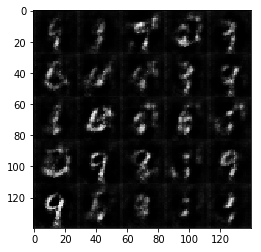

Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.8868  Iter: 210
Epoch 1/2... Discriminator Loss: 1.6058... Generator Loss: 0.3511  Iter: 220
Epoch 1/2... Discriminator Loss: 1.8158... Generator Loss: 0.2220  Iter: 230
Epoch 1/2... Discriminator Loss: 1.5025... Generator Loss: 0.3699  Iter: 240
Epoch 1/2... Discriminator Loss: 1.9280... Generator Loss: 0.2114  Iter: 250
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.4211  Iter: 260
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.3554  Iter: 270
Epoch 1/2... Discriminator Loss: 1.7860... Generator Loss: 0.2332  Iter: 280
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.5485  Iter: 290
Epoch 1/2... Discriminator Loss: 1.8983... Generator Loss: 0.1924  Iter: 300


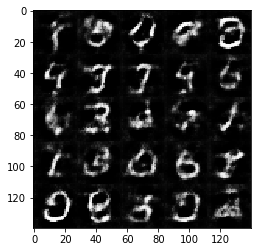

Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.4547  Iter: 310
Epoch 1/2... Discriminator Loss: 1.1519... Generator Loss: 1.5744  Iter: 320
Epoch 1/2... Discriminator Loss: 1.4012... Generator Loss: 1.4933  Iter: 330
Epoch 1/2... Discriminator Loss: 1.2814... Generator Loss: 1.3090  Iter: 340
Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.1796  Iter: 350
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 1.6261  Iter: 360
Epoch 1/2... Discriminator Loss: 1.0866... Generator Loss: 1.2179  Iter: 370
Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.9124  Iter: 380
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 0.9993  Iter: 390
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 0.9235  Iter: 400


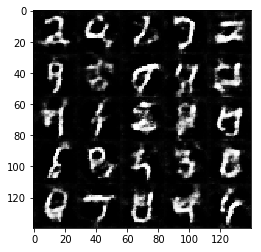

Epoch 1/2... Discriminator Loss: 1.1416... Generator Loss: 1.6199  Iter: 410
Epoch 1/2... Discriminator Loss: 1.1046... Generator Loss: 1.4608  Iter: 420
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 1.0789  Iter: 430
Epoch 1/2... Discriminator Loss: 1.1890... Generator Loss: 1.5661  Iter: 440
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.8393  Iter: 450
Epoch 1/2... Discriminator Loss: 1.1398... Generator Loss: 1.7767  Iter: 460
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 1.9734  Iter: 470
Epoch 1/2... Discriminator Loss: 1.2090... Generator Loss: 0.5365  Iter: 480
Epoch 1/2... Discriminator Loss: 1.7255... Generator Loss: 0.2356  Iter: 490
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.0643  Iter: 500


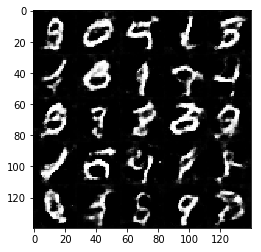

Epoch 1/2... Discriminator Loss: 1.8240... Generator Loss: 0.2113  Iter: 510
Epoch 1/2... Discriminator Loss: 1.7774... Generator Loss: 0.2388  Iter: 520
Epoch 1/2... Discriminator Loss: 0.9498... Generator Loss: 0.7924  Iter: 530
Epoch 1/2... Discriminator Loss: 1.2191... Generator Loss: 1.5142  Iter: 540
Epoch 1/2... Discriminator Loss: 0.9529... Generator Loss: 1.1111  Iter: 550
Epoch 1/2... Discriminator Loss: 0.8229... Generator Loss: 1.1348  Iter: 560
Epoch 1/2... Discriminator Loss: 0.9345... Generator Loss: 1.1911  Iter: 570
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 1.6723  Iter: 580
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 2.0194  Iter: 590
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 1.0218  Iter: 600


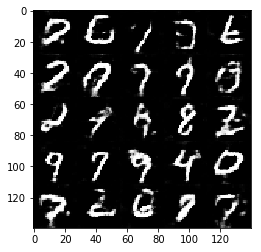

Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 0.8040  Iter: 610
Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 1.0763  Iter: 620
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 1.3511  Iter: 630
Epoch 1/2... Discriminator Loss: 1.6286... Generator Loss: 0.2875  Iter: 640
Epoch 1/2... Discriminator Loss: 1.1763... Generator Loss: 0.5278  Iter: 650
Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 0.8393  Iter: 660
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.3022  Iter: 670
Epoch 1/2... Discriminator Loss: 1.9801... Generator Loss: 0.1991  Iter: 680
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.3549  Iter: 690
Epoch 1/2... Discriminator Loss: 1.7235... Generator Loss: 0.2583  Iter: 700


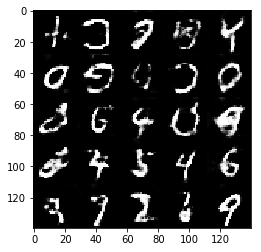

Epoch 1/2... Discriminator Loss: 1.4285... Generator Loss: 0.3449  Iter: 710
Epoch 1/2... Discriminator Loss: 2.4159... Generator Loss: 0.1416  Iter: 720
Epoch 1/2... Discriminator Loss: 1.2410... Generator Loss: 0.4728  Iter: 730
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.7101  Iter: 740
Epoch 1/2... Discriminator Loss: 0.7690... Generator Loss: 1.2043  Iter: 750
Epoch 1/2... Discriminator Loss: 1.5567... Generator Loss: 3.2045  Iter: 760
Epoch 1/2... Discriminator Loss: 0.7605... Generator Loss: 1.3755  Iter: 770
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 2.1731  Iter: 780
Epoch 1/2... Discriminator Loss: 1.1876... Generator Loss: 0.4774  Iter: 790
Epoch 1/2... Discriminator Loss: 0.7805... Generator Loss: 0.7925  Iter: 800


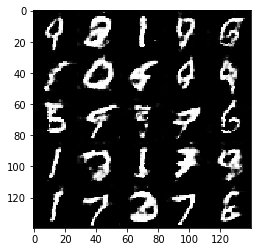

Epoch 1/2... Discriminator Loss: 1.0183... Generator Loss: 0.6528  Iter: 810
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.3690  Iter: 820
Epoch 1/2... Discriminator Loss: 0.9404... Generator Loss: 0.6936  Iter: 830
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.4559  Iter: 840
Epoch 1/2... Discriminator Loss: 0.6146... Generator Loss: 1.4353  Iter: 850
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.7800  Iter: 860
Epoch 1/2... Discriminator Loss: 0.5897... Generator Loss: 1.6347  Iter: 870
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 2.5661  Iter: 880
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.6902  Iter: 890
Epoch 1/2... Discriminator Loss: 0.8838... Generator Loss: 2.3249  Iter: 900


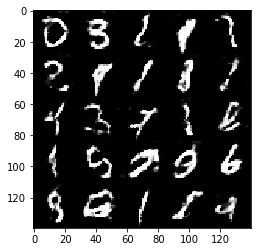

Epoch 1/2... Discriminator Loss: 1.2915... Generator Loss: 0.5008  Iter: 910
Epoch 1/2... Discriminator Loss: 0.6680... Generator Loss: 1.0251  Iter: 920
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.3178  Iter: 930
Epoch 1/2... Discriminator Loss: 2.3225... Generator Loss: 0.1471  Iter: 940
Epoch 1/2... Discriminator Loss: 2.6200... Generator Loss: 0.0935  Iter: 950
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.2587  Iter: 960
Epoch 1/2... Discriminator Loss: 0.6471... Generator Loss: 1.5736  Iter: 970
Epoch 1/2... Discriminator Loss: 1.3769... Generator Loss: 0.4228  Iter: 980
Epoch 1/2... Discriminator Loss: 1.5599... Generator Loss: 0.3259  Iter: 990
Epoch 1/2... Discriminator Loss: 2.2141... Generator Loss: 0.1694  Iter: 1000


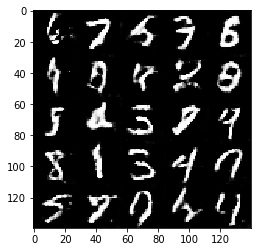

Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.6089  Iter: 1010
Epoch 1/2... Discriminator Loss: 0.9149... Generator Loss: 0.7766  Iter: 1020
Epoch 1/2... Discriminator Loss: 0.5903... Generator Loss: 1.5231  Iter: 1030
Epoch 1/2... Discriminator Loss: 0.9830... Generator Loss: 2.7433  Iter: 1040
Epoch 1/2... Discriminator Loss: 0.8262... Generator Loss: 1.0290  Iter: 1050
Epoch 1/2... Discriminator Loss: 0.8117... Generator Loss: 0.8134  Iter: 1060
Epoch 1/2... Discriminator Loss: 0.7363... Generator Loss: 1.6500  Iter: 1070
Epoch 1/2... Discriminator Loss: 0.7306... Generator Loss: 0.8076  Iter: 1080
Epoch 1/2... Discriminator Loss: 1.5706... Generator Loss: 0.3362  Iter: 1090
Epoch 1/2... Discriminator Loss: 0.7567... Generator Loss: 0.9113  Iter: 1100


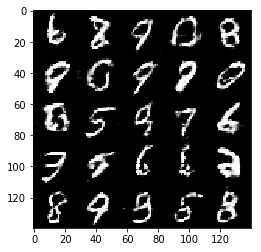

Epoch 1/2... Discriminator Loss: 0.7594... Generator Loss: 0.8713  Iter: 1110
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 2.1339  Iter: 1120
Epoch 1/2... Discriminator Loss: 0.6817... Generator Loss: 1.1489  Iter: 1130
Epoch 1/2... Discriminator Loss: 1.6447... Generator Loss: 0.2885  Iter: 1140
Epoch 1/2... Discriminator Loss: 0.5562... Generator Loss: 1.3392  Iter: 1150
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.4775  Iter: 1160
Epoch 1/2... Discriminator Loss: 0.9839... Generator Loss: 3.0732  Iter: 1170
Epoch 1/2... Discriminator Loss: 0.4449... Generator Loss: 1.2992  Iter: 1180
Epoch 1/2... Discriminator Loss: 0.8555... Generator Loss: 3.2648  Iter: 1190
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 0.6382  Iter: 1200


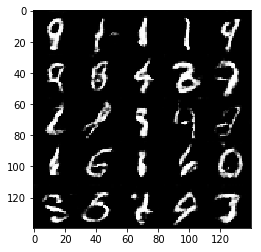

Epoch 1/2... Discriminator Loss: 0.9749... Generator Loss: 2.0460  Iter: 1210
Epoch 1/2... Discriminator Loss: 1.6727... Generator Loss: 0.3106  Iter: 1220
Epoch 1/2... Discriminator Loss: 1.2849... Generator Loss: 0.4723  Iter: 1230
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 0.9072  Iter: 1240
Epoch 1/2... Discriminator Loss: 1.1368... Generator Loss: 0.5859  Iter: 1250
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.5037  Iter: 1260
Epoch 1/2... Discriminator Loss: 1.5276... Generator Loss: 0.4003  Iter: 1270
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 0.8502  Iter: 1280
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.5992  Iter: 1290
Epoch 1/2... Discriminator Loss: 0.7152... Generator Loss: 0.9689  Iter: 1300


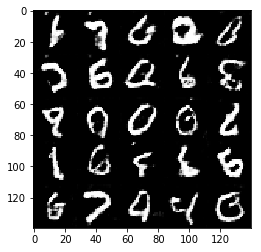

Epoch 1/2... Discriminator Loss: 0.6894... Generator Loss: 1.1254  Iter: 1310
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.5355  Iter: 1320
Epoch 1/2... Discriminator Loss: 0.9944... Generator Loss: 0.7193  Iter: 1330
Epoch 1/2... Discriminator Loss: 0.7372... Generator Loss: 1.4435  Iter: 1340
Epoch 1/2... Discriminator Loss: 1.6818... Generator Loss: 0.3272  Iter: 1350
Epoch 1/2... Discriminator Loss: 0.7232... Generator Loss: 1.2214  Iter: 1360
Epoch 1/2... Discriminator Loss: 2.0991... Generator Loss: 0.2616  Iter: 1370
Epoch 1/2... Discriminator Loss: 1.4037... Generator Loss: 0.3613  Iter: 1380
Epoch 1/2... Discriminator Loss: 0.3542... Generator Loss: 1.7320  Iter: 1390
Epoch 1/2... Discriminator Loss: 0.3915... Generator Loss: 2.4619  Iter: 1400


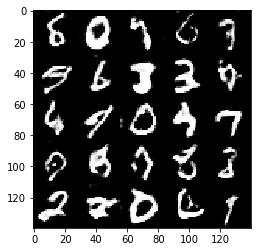

Epoch 1/2... Discriminator Loss: 1.5331... Generator Loss: 0.3633  Iter: 1410
Epoch 1/2... Discriminator Loss: 2.4982... Generator Loss: 0.1451  Iter: 1420
Epoch 1/2... Discriminator Loss: 0.8217... Generator Loss: 0.8132  Iter: 1430
Epoch 1/2... Discriminator Loss: 1.7546... Generator Loss: 0.3125  Iter: 1440
Epoch 1/2... Discriminator Loss: 0.6558... Generator Loss: 1.5410  Iter: 1450
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.2432  Iter: 1460
Epoch 1/2... Discriminator Loss: 0.4656... Generator Loss: 2.1794  Iter: 1470
Epoch 1/2... Discriminator Loss: 1.3705... Generator Loss: 0.4339  Iter: 1480
Epoch 1/2... Discriminator Loss: 1.3649... Generator Loss: 0.3855  Iter: 1490
Epoch 1/2... Discriminator Loss: 1.1689... Generator Loss: 0.5093  Iter: 1500


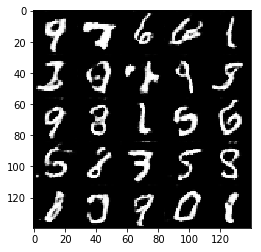

Epoch 1/2... Discriminator Loss: 0.8788... Generator Loss: 2.6605  Iter: 1510
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.5394  Iter: 1520
Epoch 1/2... Discriminator Loss: 0.8355... Generator Loss: 0.8755  Iter: 1530
Epoch 1/2... Discriminator Loss: 0.7324... Generator Loss: 0.8763  Iter: 1540
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 2.8912  Iter: 1550
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 1.2526  Iter: 1560
Epoch 1/2... Discriminator Loss: 0.6515... Generator Loss: 1.0569  Iter: 1570
Epoch 1/2... Discriminator Loss: 2.3549... Generator Loss: 0.1483  Iter: 1580
Epoch 1/2... Discriminator Loss: 1.0277... Generator Loss: 0.7143  Iter: 1590
Epoch 1/2... Discriminator Loss: 0.4000... Generator Loss: 1.5229  Iter: 1600


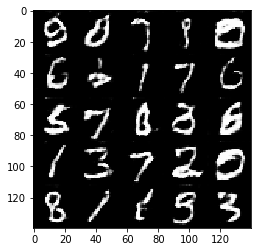

Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 1.7798  Iter: 1610
Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 2.0861  Iter: 1620
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 0.4833  Iter: 1630
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 4.1664  Iter: 1640
Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 2.7561  Iter: 1650
Epoch 1/2... Discriminator Loss: 0.7674... Generator Loss: 0.9462  Iter: 1660
Epoch 1/2... Discriminator Loss: 1.0178... Generator Loss: 3.9028  Iter: 1670
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 1.7033  Iter: 1680
Epoch 1/2... Discriminator Loss: 2.0452... Generator Loss: 0.2192  Iter: 1690
Epoch 1/2... Discriminator Loss: 0.4971... Generator Loss: 1.3753  Iter: 1700


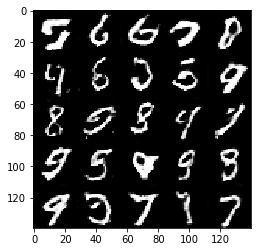

Epoch 1/2... Discriminator Loss: 0.6206... Generator Loss: 1.3358  Iter: 1710
Epoch 1/2... Discriminator Loss: 0.5311... Generator Loss: 1.3855  Iter: 1720
Epoch 1/2... Discriminator Loss: 0.5082... Generator Loss: 2.5011  Iter: 1730
Epoch 1/2... Discriminator Loss: 0.7722... Generator Loss: 1.7764  Iter: 1740
Epoch 1/2... Discriminator Loss: 0.6367... Generator Loss: 1.8454  Iter: 1750
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.3959  Iter: 1760
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.5148  Iter: 1770
Epoch 1/2... Discriminator Loss: 1.9475... Generator Loss: 0.1901  Iter: 1780
Epoch 1/2... Discriminator Loss: 0.4632... Generator Loss: 1.3811  Iter: 1790
Epoch 1/2... Discriminator Loss: 1.5716... Generator Loss: 0.4354  Iter: 1800


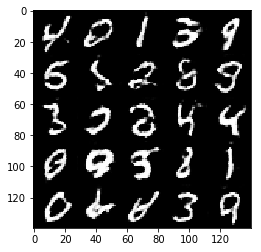

Epoch 1/2... Discriminator Loss: 1.4703... Generator Loss: 0.4254  Iter: 1810
Epoch 1/2... Discriminator Loss: 1.4608... Generator Loss: 0.5154  Iter: 1820
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 0.8652  Iter: 1830
Epoch 1/2... Discriminator Loss: 1.7804... Generator Loss: 0.3231  Iter: 1840
Epoch 1/2... Discriminator Loss: 1.7442... Generator Loss: 5.0367  Iter: 1850
Epoch 1/2... Discriminator Loss: 1.1527... Generator Loss: 0.6035  Iter: 1860
Epoch 1/2... Discriminator Loss: 1.6606... Generator Loss: 0.2920  Iter: 1870
Epoch 2/2... Discriminator Loss: 1.3433... Generator Loss: 0.5829  Iter: 1880
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.1956  Iter: 1890
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 2.5636  Iter: 1900


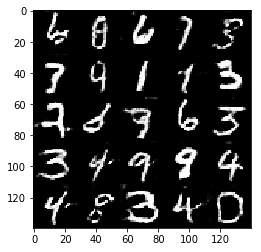

Epoch 2/2... Discriminator Loss: 1.2810... Generator Loss: 3.5128  Iter: 1910
Epoch 2/2... Discriminator Loss: 0.6872... Generator Loss: 1.0684  Iter: 1920
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 3.0821  Iter: 1930
Epoch 2/2... Discriminator Loss: 0.6854... Generator Loss: 1.2541  Iter: 1940
Epoch 2/2... Discriminator Loss: 0.3147... Generator Loss: 1.8590  Iter: 1950
Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.1095  Iter: 1960
Epoch 2/2... Discriminator Loss: 2.4452... Generator Loss: 0.2391  Iter: 1970
Epoch 2/2... Discriminator Loss: 1.7547... Generator Loss: 0.3553  Iter: 1980
Epoch 2/2... Discriminator Loss: 0.8794... Generator Loss: 0.8564  Iter: 1990
Epoch 2/2... Discriminator Loss: 0.7464... Generator Loss: 0.9780  Iter: 2000


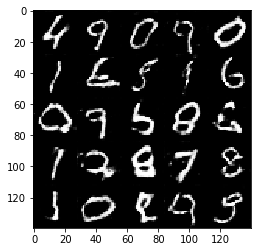

Epoch 2/2... Discriminator Loss: 0.7616... Generator Loss: 0.8994  Iter: 2010
Epoch 2/2... Discriminator Loss: 0.4170... Generator Loss: 1.7692  Iter: 2020
Epoch 2/2... Discriminator Loss: 0.3158... Generator Loss: 2.6514  Iter: 2030
Epoch 2/2... Discriminator Loss: 0.6625... Generator Loss: 1.0312  Iter: 2040
Epoch 2/2... Discriminator Loss: 0.5790... Generator Loss: 1.3376  Iter: 2050
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 0.5833  Iter: 2060
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 0.9364  Iter: 2070
Epoch 2/2... Discriminator Loss: 0.4890... Generator Loss: 2.8852  Iter: 2080
Epoch 2/2... Discriminator Loss: 0.6005... Generator Loss: 1.1268  Iter: 2090
Epoch 2/2... Discriminator Loss: 0.7261... Generator Loss: 1.0659  Iter: 2100


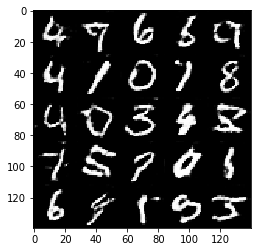

Epoch 2/2... Discriminator Loss: 0.7151... Generator Loss: 1.1231  Iter: 2110
Epoch 2/2... Discriminator Loss: 0.4360... Generator Loss: 1.4437  Iter: 2120
Epoch 2/2... Discriminator Loss: 0.7205... Generator Loss: 0.9147  Iter: 2130
Epoch 2/2... Discriminator Loss: 0.4185... Generator Loss: 2.0354  Iter: 2140
Epoch 2/2... Discriminator Loss: 0.3836... Generator Loss: 1.5747  Iter: 2150
Epoch 2/2... Discriminator Loss: 1.1834... Generator Loss: 0.5292  Iter: 2160
Epoch 2/2... Discriminator Loss: 0.6440... Generator Loss: 1.0392  Iter: 2170
Epoch 2/2... Discriminator Loss: 0.4933... Generator Loss: 1.3907  Iter: 2180
Epoch 2/2... Discriminator Loss: 1.0942... Generator Loss: 0.6121  Iter: 2190
Epoch 2/2... Discriminator Loss: 0.4597... Generator Loss: 1.4552  Iter: 2200


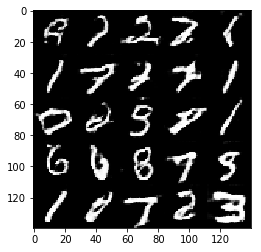

Epoch 2/2... Discriminator Loss: 1.7152... Generator Loss: 0.3337  Iter: 2210
Epoch 2/2... Discriminator Loss: 0.3135... Generator Loss: 1.8639  Iter: 2220
Epoch 2/2... Discriminator Loss: 2.9618... Generator Loss: 0.1147  Iter: 2230
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.6328  Iter: 2240
Epoch 2/2... Discriminator Loss: 0.6086... Generator Loss: 1.5914  Iter: 2250
Epoch 2/2... Discriminator Loss: 0.8588... Generator Loss: 4.4917  Iter: 2260
Epoch 2/2... Discriminator Loss: 0.5236... Generator Loss: 3.0688  Iter: 2270
Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 1.5862  Iter: 2280
Epoch 2/2... Discriminator Loss: 0.4887... Generator Loss: 1.3871  Iter: 2290
Epoch 2/2... Discriminator Loss: 2.1405... Generator Loss: 0.2024  Iter: 2300


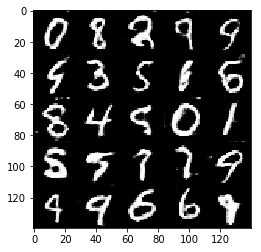

Epoch 2/2... Discriminator Loss: 0.4428... Generator Loss: 1.3887  Iter: 2310
Epoch 2/2... Discriminator Loss: 0.4446... Generator Loss: 1.5130  Iter: 2320
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 2.4896  Iter: 2330
Epoch 2/2... Discriminator Loss: 0.6081... Generator Loss: 1.4435  Iter: 2340
Epoch 2/2... Discriminator Loss: 1.4999... Generator Loss: 0.3214  Iter: 2350
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 0.5621  Iter: 2360
Epoch 2/2... Discriminator Loss: 1.5897... Generator Loss: 0.3253  Iter: 2370
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.0014  Iter: 2380
Epoch 2/2... Discriminator Loss: 1.9481... Generator Loss: 0.2374  Iter: 2390
Epoch 2/2... Discriminator Loss: 0.3900... Generator Loss: 1.6570  Iter: 2400


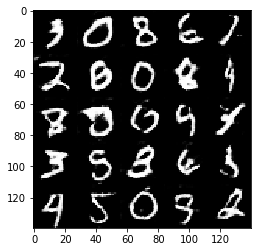

Epoch 2/2... Discriminator Loss: 0.4345... Generator Loss: 1.3489  Iter: 2410
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 0.5951  Iter: 2420
Epoch 2/2... Discriminator Loss: 0.6588... Generator Loss: 1.0198  Iter: 2430
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 3.4439  Iter: 2440
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.7346  Iter: 2450
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.4231  Iter: 2460
Epoch 2/2... Discriminator Loss: 0.4834... Generator Loss: 1.2977  Iter: 2470
Epoch 2/2... Discriminator Loss: 1.3023... Generator Loss: 0.4176  Iter: 2480
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 1.0523  Iter: 2490
Epoch 2/2... Discriminator Loss: 0.4250... Generator Loss: 2.6599  Iter: 2500


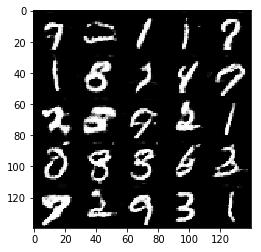

Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.2075  Iter: 2510
Epoch 2/2... Discriminator Loss: 1.1428... Generator Loss: 0.5260  Iter: 2520
Epoch 2/2... Discriminator Loss: 0.4763... Generator Loss: 2.0794  Iter: 2530
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 0.9885  Iter: 2540
Epoch 2/2... Discriminator Loss: 1.7074... Generator Loss: 0.3656  Iter: 2550
Epoch 2/2... Discriminator Loss: 0.3329... Generator Loss: 1.7036  Iter: 2560
Epoch 2/2... Discriminator Loss: 0.9549... Generator Loss: 0.6404  Iter: 2570
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.4904  Iter: 2580
Epoch 2/2... Discriminator Loss: 0.3740... Generator Loss: 1.6527  Iter: 2590
Epoch 2/2... Discriminator Loss: 0.4360... Generator Loss: 1.8838  Iter: 2600


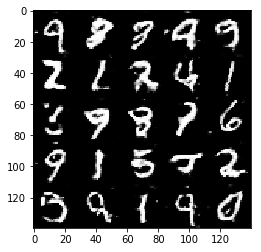

Epoch 2/2... Discriminator Loss: 1.6215... Generator Loss: 0.5102  Iter: 2610
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 1.8778  Iter: 2620
Epoch 2/2... Discriminator Loss: 0.3259... Generator Loss: 1.9265  Iter: 2630
Epoch 2/2... Discriminator Loss: 0.5742... Generator Loss: 1.4137  Iter: 2640
Epoch 2/2... Discriminator Loss: 2.1442... Generator Loss: 0.4455  Iter: 2650
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.3618  Iter: 2660
Epoch 2/2... Discriminator Loss: 0.4527... Generator Loss: 1.3791  Iter: 2670
Epoch 2/2... Discriminator Loss: 1.2589... Generator Loss: 0.6896  Iter: 2680
Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 0.9510  Iter: 2690
Epoch 2/2... Discriminator Loss: 0.4469... Generator Loss: 1.3445  Iter: 2700


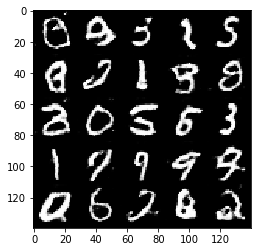

Epoch 2/2... Discriminator Loss: 0.8768... Generator Loss: 1.0015  Iter: 2710
Epoch 2/2... Discriminator Loss: 0.7048... Generator Loss: 1.0417  Iter: 2720
Epoch 2/2... Discriminator Loss: 0.3269... Generator Loss: 2.2496  Iter: 2730
Epoch 2/2... Discriminator Loss: 0.5009... Generator Loss: 1.2898  Iter: 2740
Epoch 2/2... Discriminator Loss: 2.4017... Generator Loss: 5.8656  Iter: 2750
Epoch 2/2... Discriminator Loss: 0.3451... Generator Loss: 3.5541  Iter: 2760
Epoch 2/2... Discriminator Loss: 0.4738... Generator Loss: 1.3614  Iter: 2770
Epoch 2/2... Discriminator Loss: 1.0174... Generator Loss: 0.8074  Iter: 2780
Epoch 2/2... Discriminator Loss: 0.8090... Generator Loss: 1.0027  Iter: 2790
Epoch 2/2... Discriminator Loss: 1.0976... Generator Loss: 0.7430  Iter: 2800


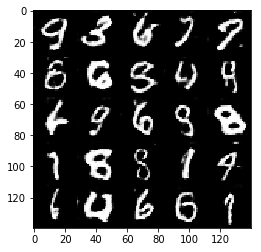

Epoch 2/2... Discriminator Loss: 0.4711... Generator Loss: 1.3576  Iter: 2810
Epoch 2/2... Discriminator Loss: 0.7564... Generator Loss: 0.8711  Iter: 2820
Epoch 2/2... Discriminator Loss: 1.1510... Generator Loss: 0.6411  Iter: 2830
Epoch 2/2... Discriminator Loss: 0.3738... Generator Loss: 1.7438  Iter: 2840
Epoch 2/2... Discriminator Loss: 2.2993... Generator Loss: 0.2566  Iter: 2850
Epoch 2/2... Discriminator Loss: 0.6544... Generator Loss: 1.0379  Iter: 2860
Epoch 2/2... Discriminator Loss: 0.1348... Generator Loss: 2.7690  Iter: 2870
Epoch 2/2... Discriminator Loss: 0.2582... Generator Loss: 2.3580  Iter: 2880
Epoch 2/2... Discriminator Loss: 2.9437... Generator Loss: 0.1591  Iter: 2890
Epoch 2/2... Discriminator Loss: 0.4560... Generator Loss: 1.5494  Iter: 2900


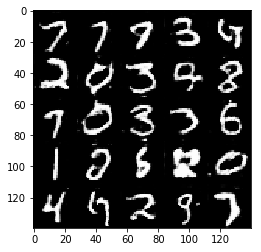

Epoch 2/2... Discriminator Loss: 0.2121... Generator Loss: 2.4077  Iter: 2910
Epoch 2/2... Discriminator Loss: 0.9609... Generator Loss: 0.8016  Iter: 2920
Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 1.6892  Iter: 2930
Epoch 2/2... Discriminator Loss: 0.3434... Generator Loss: 1.7409  Iter: 2940
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.4800  Iter: 2950
Epoch 2/2... Discriminator Loss: 0.7478... Generator Loss: 0.9712  Iter: 2960
Epoch 2/2... Discriminator Loss: 0.8425... Generator Loss: 3.3308  Iter: 2970
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 1.0225  Iter: 2980
Epoch 2/2... Discriminator Loss: 0.9369... Generator Loss: 0.7598  Iter: 2990
Epoch 2/2... Discriminator Loss: 1.2925... Generator Loss: 0.5357  Iter: 3000


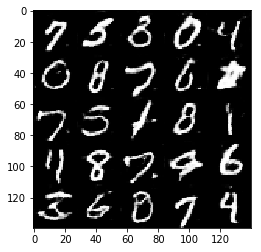

Epoch 2/2... Discriminator Loss: 0.8795... Generator Loss: 1.0220  Iter: 3010
Epoch 2/2... Discriminator Loss: 0.6260... Generator Loss: 3.5183  Iter: 3020
Epoch 2/2... Discriminator Loss: 2.5998... Generator Loss: 0.1550  Iter: 3030
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 0.8006  Iter: 3040
Epoch 2/2... Discriminator Loss: 0.3463... Generator Loss: 2.7179  Iter: 3050
Epoch 2/2... Discriminator Loss: 0.4017... Generator Loss: 2.6293  Iter: 3060
Epoch 2/2... Discriminator Loss: 2.5123... Generator Loss: 0.2241  Iter: 3070
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 1.1211  Iter: 3080
Epoch 2/2... Discriminator Loss: 0.5039... Generator Loss: 1.4177  Iter: 3090
Epoch 2/2... Discriminator Loss: 0.6197... Generator Loss: 1.1753  Iter: 3100


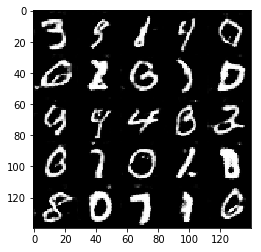

Epoch 2/2... Discriminator Loss: 0.3151... Generator Loss: 2.1283  Iter: 3110
Epoch 2/2... Discriminator Loss: 0.2132... Generator Loss: 2.2167  Iter: 3120
Epoch 2/2... Discriminator Loss: 0.7242... Generator Loss: 1.0575  Iter: 3130
Epoch 2/2... Discriminator Loss: 0.4905... Generator Loss: 1.4194  Iter: 3140
Epoch 2/2... Discriminator Loss: 1.5912... Generator Loss: 0.3619  Iter: 3150
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.0292  Iter: 3160
Epoch 2/2... Discriminator Loss: 0.3052... Generator Loss: 3.1310  Iter: 3170
Epoch 2/2... Discriminator Loss: 0.9243... Generator Loss: 0.9677  Iter: 3180
Epoch 2/2... Discriminator Loss: 0.2553... Generator Loss: 2.1852  Iter: 3190
Epoch 2/2... Discriminator Loss: 0.7615... Generator Loss: 0.8570  Iter: 3200


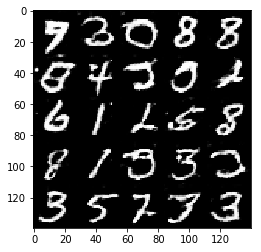

Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.1076  Iter: 3210
Epoch 2/2... Discriminator Loss: 0.2805... Generator Loss: 2.1384  Iter: 3220
Epoch 2/2... Discriminator Loss: 0.8677... Generator Loss: 3.0902  Iter: 3230
Epoch 2/2... Discriminator Loss: 2.7249... Generator Loss: 0.1221  Iter: 3240
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.6330  Iter: 3250
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 1.8536  Iter: 3260
Epoch 2/2... Discriminator Loss: 0.9159... Generator Loss: 0.7302  Iter: 3270
Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 1.6935  Iter: 3280
Epoch 2/2... Discriminator Loss: 0.4660... Generator Loss: 1.3494  Iter: 3290
Epoch 2/2... Discriminator Loss: 0.6838... Generator Loss: 1.0591  Iter: 3300


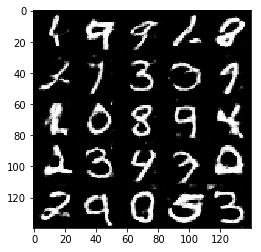

Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 1.2606  Iter: 3310
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 0.9772  Iter: 3320
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 0.9486  Iter: 3330
Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 1.4052  Iter: 3340
Epoch 2/2... Discriminator Loss: 0.1838... Generator Loss: 2.2811  Iter: 3350
Epoch 2/2... Discriminator Loss: 1.1535... Generator Loss: 0.5614  Iter: 3360
Epoch 2/2... Discriminator Loss: 0.3195... Generator Loss: 1.9461  Iter: 3370
Epoch 2/2... Discriminator Loss: 0.3488... Generator Loss: 1.8451  Iter: 3380
Epoch 2/2... Discriminator Loss: 2.7545... Generator Loss: 0.1439  Iter: 3390
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 1.3069  Iter: 3400


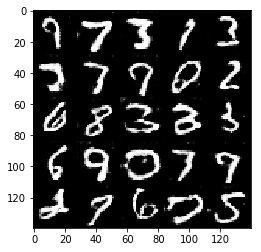

Epoch 2/2... Discriminator Loss: 1.3835... Generator Loss: 0.4078  Iter: 3410
Epoch 2/2... Discriminator Loss: 0.3410... Generator Loss: 1.7582  Iter: 3420
Epoch 2/2... Discriminator Loss: 0.5542... Generator Loss: 1.2634  Iter: 3430
Epoch 2/2... Discriminator Loss: 0.7129... Generator Loss: 0.9230  Iter: 3440
Epoch 2/2... Discriminator Loss: 0.3446... Generator Loss: 1.8647  Iter: 3450
Epoch 2/2... Discriminator Loss: 1.9227... Generator Loss: 0.3071  Iter: 3460
Epoch 2/2... Discriminator Loss: 0.5720... Generator Loss: 1.1926  Iter: 3470
Epoch 2/2... Discriminator Loss: 0.7103... Generator Loss: 1.2062  Iter: 3480
Epoch 2/2... Discriminator Loss: 0.3835... Generator Loss: 1.7760  Iter: 3490
Epoch 2/2... Discriminator Loss: 0.2257... Generator Loss: 2.2115  Iter: 3500


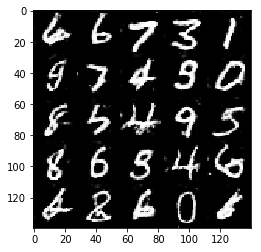

Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 0.8987  Iter: 3510
Epoch 2/2... Discriminator Loss: 0.3499... Generator Loss: 1.6672  Iter: 3520
Epoch 2/2... Discriminator Loss: 0.2899... Generator Loss: 2.4038  Iter: 3530
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.3742  Iter: 3540
Epoch 2/2... Discriminator Loss: 0.8289... Generator Loss: 3.2209  Iter: 3550
Epoch 2/2... Discriminator Loss: 0.3257... Generator Loss: 3.0980  Iter: 3560
Epoch 2/2... Discriminator Loss: 1.8440... Generator Loss: 0.5767  Iter: 3570
Epoch 2/2... Discriminator Loss: 0.5482... Generator Loss: 1.1368  Iter: 3580
Epoch 2/2... Discriminator Loss: 0.3869... Generator Loss: 1.6493  Iter: 3590
Epoch 2/2... Discriminator Loss: 3.1382... Generator Loss: 0.0729  Iter: 3600


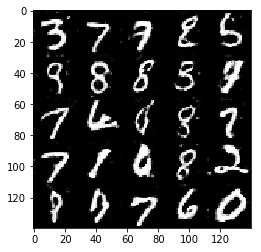

Epoch 2/2... Discriminator Loss: 0.3493... Generator Loss: 2.1386  Iter: 3610
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 2.0715  Iter: 3620
Epoch 2/2... Discriminator Loss: 0.4682... Generator Loss: 1.5900  Iter: 3630
Epoch 2/2... Discriminator Loss: 0.3315... Generator Loss: 1.7656  Iter: 3640
Epoch 2/2... Discriminator Loss: 0.3533... Generator Loss: 1.7790  Iter: 3650
Epoch 2/2... Discriminator Loss: 0.3905... Generator Loss: 1.5318  Iter: 3660
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 1.1507  Iter: 3670
Epoch 2/2... Discriminator Loss: 0.1813... Generator Loss: 2.8824  Iter: 3680
Epoch 2/2... Discriminator Loss: 1.0753... Generator Loss: 0.7177  Iter: 3690
Epoch 2/2... Discriminator Loss: 0.4491... Generator Loss: 1.6554  Iter: 3700


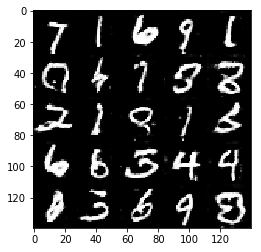

Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 1.6399  Iter: 3710
Epoch 2/2... Discriminator Loss: 0.3503... Generator Loss: 1.7361  Iter: 3720
Epoch 2/2... Discriminator Loss: 0.3829... Generator Loss: 2.2724  Iter: 3730
Epoch 2/2... Discriminator Loss: 0.5718... Generator Loss: 1.1229  Iter: 3740
Epoch 2/2... Discriminator Loss: 0.4587... Generator Loss: 1.4358  Iter: 3750


In [12]:
batch_size = 32
z_dim = 100
learning_rate = .0006
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

shape: 28 28 3
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 0.4234  Iter: 10
Epoch 1/1... Discriminator Loss: 0.3624... Generator Loss: 1.2366  Iter: 20
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 17.3558  Iter: 30
Epoch 1/1... Discriminator Loss: 0.3013... Generator Loss: 9.7469  Iter: 40
Epoch 1/1... Discriminator Loss: 2.2745... Generator Loss: 0.3858  Iter: 50
Epoch 1/1... Discriminator Loss: 0.2444... Generator Loss: 2.2050  Iter: 60
Epoch 1/1... Discriminator Loss: 0.1875... Generator Loss: 4.3850  Iter: 70
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.3584  Iter: 80
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 1.1036  Iter: 90
Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.8377  Iter: 100


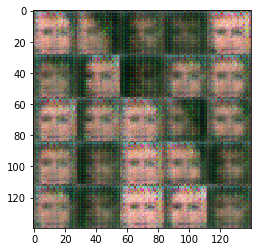

Epoch 1/1... Discriminator Loss: 0.4973... Generator Loss: 1.5539  Iter: 110
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 1.7774  Iter: 120
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.4568  Iter: 130
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.8493  Iter: 140
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6055  Iter: 150
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 2.1476  Iter: 160
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 0.7785  Iter: 170
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7896  Iter: 180
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 2.6753  Iter: 190
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7056  Iter: 200


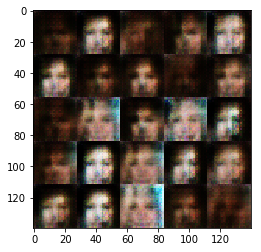

Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9214  Iter: 210
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 2.0214  Iter: 220
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.2794  Iter: 230
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.3823  Iter: 240
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.8577  Iter: 250
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 0.9060  Iter: 260
Epoch 1/1... Discriminator Loss: 1.6532... Generator Loss: 0.3494  Iter: 270
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.1459  Iter: 280
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.8157  Iter: 290
Epoch 1/1... Discriminator Loss: 1.1063... Generator Loss: 0.9711  Iter: 300


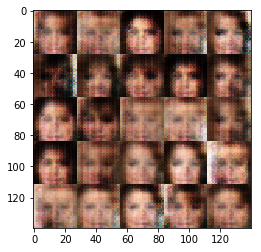

Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.7369  Iter: 310
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 1.2838  Iter: 320
Epoch 1/1... Discriminator Loss: 1.1525... Generator Loss: 0.7725  Iter: 330
Epoch 1/1... Discriminator Loss: 0.8102... Generator Loss: 1.1428  Iter: 340
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.4909  Iter: 350
Epoch 1/1... Discriminator Loss: 2.0696... Generator Loss: 2.6819  Iter: 360
Epoch 1/1... Discriminator Loss: 1.1210... Generator Loss: 1.5768  Iter: 370
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.2803  Iter: 380
Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.2360  Iter: 390
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.7543  Iter: 400


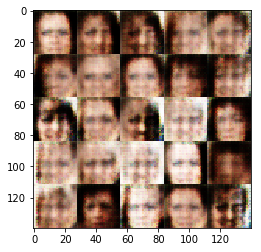

Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.4325  Iter: 410
Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.1771  Iter: 420
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.2095  Iter: 430
Epoch 1/1... Discriminator Loss: 1.5482... Generator Loss: 0.3170  Iter: 440
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 2.3598  Iter: 450
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.5215  Iter: 460
Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 0.8185  Iter: 470
Epoch 1/1... Discriminator Loss: 1.0262... Generator Loss: 1.1021  Iter: 480
Epoch 1/1... Discriminator Loss: 0.8635... Generator Loss: 1.0832  Iter: 490
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.5626  Iter: 500


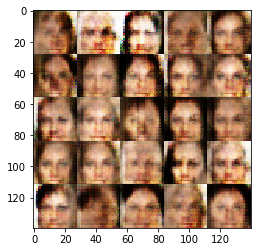

Epoch 1/1... Discriminator Loss: 2.3911... Generator Loss: 0.1147  Iter: 510
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.1345  Iter: 520
Epoch 1/1... Discriminator Loss: 0.9322... Generator Loss: 1.2757  Iter: 530
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.3751  Iter: 540
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.2884  Iter: 550
Epoch 1/1... Discriminator Loss: 0.8689... Generator Loss: 0.8328  Iter: 560
Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 0.8302  Iter: 570
Epoch 1/1... Discriminator Loss: 0.4710... Generator Loss: 1.6627  Iter: 580
Epoch 1/1... Discriminator Loss: 1.1142... Generator Loss: 0.6515  Iter: 590
Epoch 1/1... Discriminator Loss: 1.3917... Generator Loss: 2.2031  Iter: 600


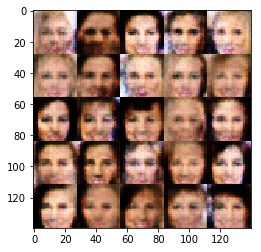

Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 2.9966  Iter: 610
Epoch 1/1... Discriminator Loss: 0.6659... Generator Loss: 0.8535  Iter: 620
Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 1.2088  Iter: 630
Epoch 1/1... Discriminator Loss: 1.0327... Generator Loss: 0.7309  Iter: 640
Epoch 1/1... Discriminator Loss: 0.8344... Generator Loss: 1.4481  Iter: 650
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.0605  Iter: 660
Epoch 1/1... Discriminator Loss: 4.2408... Generator Loss: 4.2931  Iter: 670
Epoch 1/1... Discriminator Loss: 1.0281... Generator Loss: 0.7888  Iter: 680
Epoch 1/1... Discriminator Loss: 0.8526... Generator Loss: 0.8691  Iter: 690
Epoch 1/1... Discriminator Loss: 1.7689... Generator Loss: 3.8503  Iter: 700


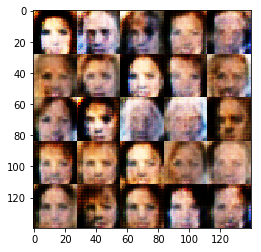

Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 0.7934  Iter: 710
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.5291  Iter: 720
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 0.9833  Iter: 730
Epoch 1/1... Discriminator Loss: 0.9013... Generator Loss: 0.8552  Iter: 740
Epoch 1/1... Discriminator Loss: 0.6652... Generator Loss: 0.8789  Iter: 750
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.4154  Iter: 760
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 1.0365  Iter: 770
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 0.9460  Iter: 780
Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.2594  Iter: 790
Epoch 1/1... Discriminator Loss: 0.4557... Generator Loss: 1.3930  Iter: 800


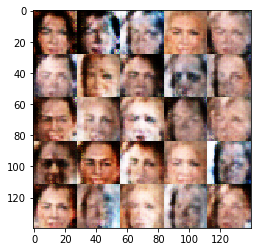

Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.4337  Iter: 810
Epoch 1/1... Discriminator Loss: 1.0264... Generator Loss: 0.8280  Iter: 820
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.3758  Iter: 830
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8885  Iter: 840
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.5704  Iter: 850
Epoch 1/1... Discriminator Loss: 0.9560... Generator Loss: 0.9768  Iter: 860
Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.3915  Iter: 870
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.3484  Iter: 880
Epoch 1/1... Discriminator Loss: 0.7148... Generator Loss: 2.6131  Iter: 890
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.5095  Iter: 900


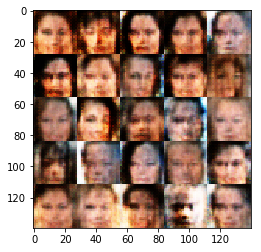

Epoch 1/1... Discriminator Loss: 0.8542... Generator Loss: 0.7025  Iter: 910
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.9947  Iter: 920
Epoch 1/1... Discriminator Loss: 0.6454... Generator Loss: 1.6210  Iter: 930
Epoch 1/1... Discriminator Loss: 0.8530... Generator Loss: 0.9724  Iter: 940
Epoch 1/1... Discriminator Loss: 0.7851... Generator Loss: 1.6186  Iter: 950
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 1.1618  Iter: 960
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.4951  Iter: 970
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 0.9233  Iter: 980
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 2.3370  Iter: 990
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.3321  Iter: 1000


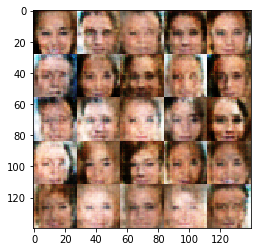

Epoch 1/1... Discriminator Loss: 0.9110... Generator Loss: 0.9168  Iter: 1010
Epoch 1/1... Discriminator Loss: 0.8761... Generator Loss: 2.6048  Iter: 1020
Epoch 1/1... Discriminator Loss: 1.8318... Generator Loss: 2.8474  Iter: 1030
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.7996  Iter: 1040
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.5165  Iter: 1050
Epoch 1/1... Discriminator Loss: 0.6386... Generator Loss: 1.9805  Iter: 1060
Epoch 1/1... Discriminator Loss: 0.9598... Generator Loss: 1.1826  Iter: 1070
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.5605  Iter: 1080
Epoch 1/1... Discriminator Loss: 0.9557... Generator Loss: 1.2149  Iter: 1090
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.6038  Iter: 1100


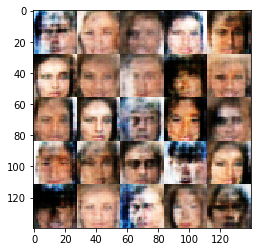

Epoch 1/1... Discriminator Loss: 0.9354... Generator Loss: 0.9873  Iter: 1110
Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.6406  Iter: 1120
Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.0300  Iter: 1130
Epoch 1/1... Discriminator Loss: 0.9483... Generator Loss: 0.8763  Iter: 1140
Epoch 1/1... Discriminator Loss: 1.8680... Generator Loss: 2.8913  Iter: 1150
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6174  Iter: 1160
Epoch 1/1... Discriminator Loss: 0.9788... Generator Loss: 0.8564  Iter: 1170
Epoch 1/1... Discriminator Loss: 1.0905... Generator Loss: 0.6127  Iter: 1180
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7463  Iter: 1190
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 1.3043  Iter: 1200


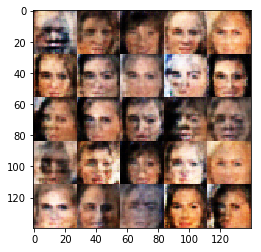

Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.6527  Iter: 1210
Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 0.7952  Iter: 1220
Epoch 1/1... Discriminator Loss: 0.9604... Generator Loss: 1.0931  Iter: 1230
Epoch 1/1... Discriminator Loss: 0.9958... Generator Loss: 0.7795  Iter: 1240
Epoch 1/1... Discriminator Loss: 1.7287... Generator Loss: 0.3159  Iter: 1250
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 1.0761  Iter: 1260
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.5853  Iter: 1270
Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.8057  Iter: 1280
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.9457  Iter: 1290
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.4407  Iter: 1300


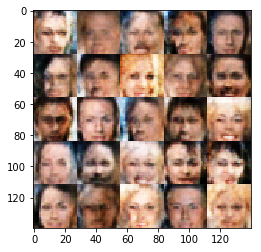

Epoch 1/1... Discriminator Loss: 1.0116... Generator Loss: 0.9551  Iter: 1310
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.6018  Iter: 1320
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 1.1755  Iter: 1330
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.3572  Iter: 1340
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.2497  Iter: 1350
Epoch 1/1... Discriminator Loss: 0.9444... Generator Loss: 0.8299  Iter: 1360
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 0.7650  Iter: 1370
Epoch 1/1... Discriminator Loss: 1.4699... Generator Loss: 0.3436  Iter: 1380
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.7222  Iter: 1390
Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.0466  Iter: 1400


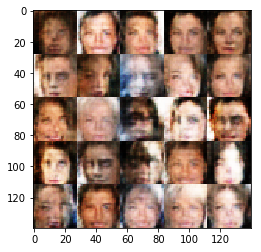

Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.3654  Iter: 1410
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.7293  Iter: 1420
Epoch 1/1... Discriminator Loss: 0.8626... Generator Loss: 1.1461  Iter: 1430
Epoch 1/1... Discriminator Loss: 1.6221... Generator Loss: 0.2938  Iter: 1440
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 1.5092  Iter: 1450
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.3463  Iter: 1460
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.9463  Iter: 1470
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 2.3219  Iter: 1480
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.5710  Iter: 1490
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 0.9672  Iter: 1500


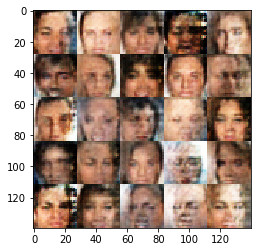

Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.4552  Iter: 1510
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.7227  Iter: 1520
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.8874  Iter: 1530
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.3636  Iter: 1540
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9194  Iter: 1550
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 1.8236  Iter: 1560
Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.5332  Iter: 1570
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.3525  Iter: 1580
Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.6136  Iter: 1590
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.4801  Iter: 1600


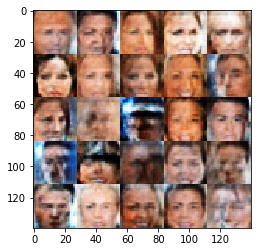

Epoch 1/1... Discriminator Loss: 0.9320... Generator Loss: 1.5380  Iter: 1610
Epoch 1/1... Discriminator Loss: 0.7836... Generator Loss: 1.0831  Iter: 1620
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.9488  Iter: 1630
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.8547  Iter: 1640
Epoch 1/1... Discriminator Loss: 0.9847... Generator Loss: 1.3851  Iter: 1650
Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.9565  Iter: 1660
Epoch 1/1... Discriminator Loss: 1.1340... Generator Loss: 0.5708  Iter: 1670
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.3931  Iter: 1680
Epoch 1/1... Discriminator Loss: 1.9986... Generator Loss: 0.1883  Iter: 1690
Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 0.9366  Iter: 1700


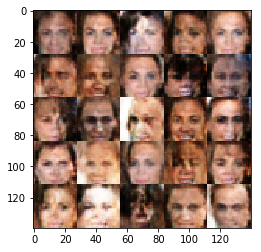

Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.4132  Iter: 1710
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.7588  Iter: 1720
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 0.4445  Iter: 1730
Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9191  Iter: 1740
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.7708  Iter: 1750
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.3251  Iter: 1760
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 0.8727  Iter: 1770
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.6211  Iter: 1780
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.7499  Iter: 1790
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 0.8074  Iter: 1800


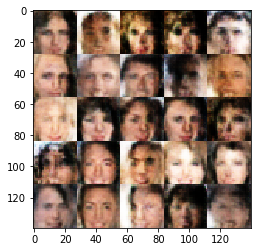

Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7678  Iter: 1810
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.0252  Iter: 1820
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 1.2991  Iter: 1830
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5072  Iter: 1840
Epoch 1/1... Discriminator Loss: 1.0212... Generator Loss: 0.8653  Iter: 1850
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.2535  Iter: 1860
Epoch 1/1... Discriminator Loss: 0.8993... Generator Loss: 0.9670  Iter: 1870
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.5615  Iter: 1880
Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.8462  Iter: 1890
Epoch 1/1... Discriminator Loss: 1.6306... Generator Loss: 0.2955  Iter: 1900


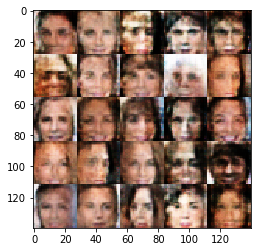

Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 0.8678  Iter: 1910
Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.0354  Iter: 1920
Epoch 1/1... Discriminator Loss: 1.0031... Generator Loss: 0.6576  Iter: 1930
Epoch 1/1... Discriminator Loss: 0.7139... Generator Loss: 1.0476  Iter: 1940
Epoch 1/1... Discriminator Loss: 0.8221... Generator Loss: 1.2421  Iter: 1950
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.4088  Iter: 1960
Epoch 1/1... Discriminator Loss: 0.7198... Generator Loss: 1.0722  Iter: 1970
Epoch 1/1... Discriminator Loss: 1.8309... Generator Loss: 0.2547  Iter: 1980
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.8023  Iter: 1990
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.4574  Iter: 2000


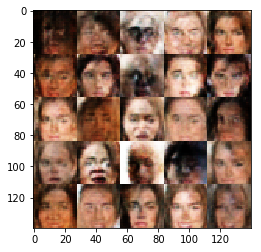

Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.6417  Iter: 2010
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.4901  Iter: 2020
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.7094  Iter: 2030
Epoch 1/1... Discriminator Loss: 1.5259... Generator Loss: 0.3729  Iter: 2040
Epoch 1/1... Discriminator Loss: 0.6512... Generator Loss: 1.4978  Iter: 2050
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.3455  Iter: 2060
Epoch 1/1... Discriminator Loss: 0.7660... Generator Loss: 1.2645  Iter: 2070
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 0.8085  Iter: 2080
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.4026  Iter: 2090
Epoch 1/1... Discriminator Loss: 0.8089... Generator Loss: 1.2067  Iter: 2100


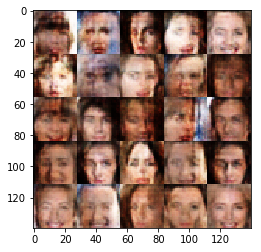

Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 1.1705  Iter: 2110
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.0150  Iter: 2120
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 0.7511  Iter: 2130
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.0109  Iter: 2140
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 0.9869  Iter: 2150
Epoch 1/1... Discriminator Loss: 0.9318... Generator Loss: 0.9013  Iter: 2160
Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.3650  Iter: 2170
Epoch 1/1... Discriminator Loss: 0.7914... Generator Loss: 2.5135  Iter: 2180
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 1.1802  Iter: 2190
Epoch 1/1... Discriminator Loss: 0.8372... Generator Loss: 0.8538  Iter: 2200


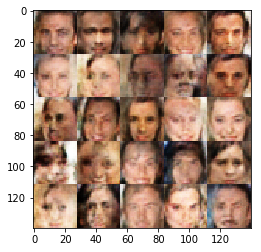

Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1106  Iter: 2210
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 0.8282  Iter: 2220
Epoch 1/1... Discriminator Loss: 0.9836... Generator Loss: 0.6544  Iter: 2230
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 1.3260  Iter: 2240
Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.2732  Iter: 2250
Epoch 1/1... Discriminator Loss: 0.7642... Generator Loss: 1.0056  Iter: 2260
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 0.6887  Iter: 2270
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.4408  Iter: 2280
Epoch 1/1... Discriminator Loss: 0.9231... Generator Loss: 1.2434  Iter: 2290
Epoch 1/1... Discriminator Loss: 0.7523... Generator Loss: 0.9894  Iter: 2300


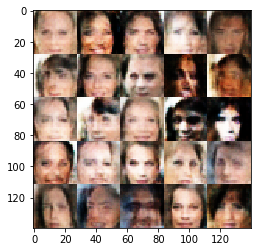

Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.2959  Iter: 2310
Epoch 1/1... Discriminator Loss: 1.1580... Generator Loss: 0.5929  Iter: 2320
Epoch 1/1... Discriminator Loss: 1.0843... Generator Loss: 1.7506  Iter: 2330
Epoch 1/1... Discriminator Loss: 0.6529... Generator Loss: 1.5399  Iter: 2340
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 0.9355  Iter: 2350
Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.4200  Iter: 2360
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.2198  Iter: 2370
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.4174  Iter: 2380
Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.3346  Iter: 2390
Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.8201  Iter: 2400


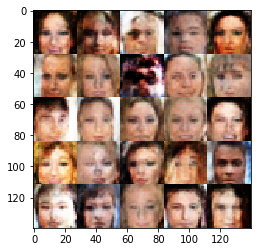

Epoch 1/1... Discriminator Loss: 0.9441... Generator Loss: 0.8535  Iter: 2410
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.4857  Iter: 2420
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.6746  Iter: 2430
Epoch 1/1... Discriminator Loss: 0.8564... Generator Loss: 0.8280  Iter: 2440
Epoch 1/1... Discriminator Loss: 0.7978... Generator Loss: 1.0442  Iter: 2450
Epoch 1/1... Discriminator Loss: 0.8644... Generator Loss: 0.8505  Iter: 2460
Epoch 1/1... Discriminator Loss: 2.0220... Generator Loss: 0.1713  Iter: 2470
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.4294  Iter: 2480
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.6448  Iter: 2490
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.6146  Iter: 2500


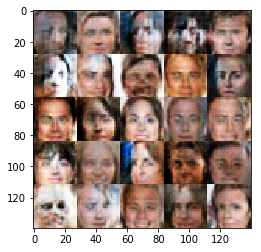

Epoch 1/1... Discriminator Loss: 0.9203... Generator Loss: 1.2660  Iter: 2510
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.4430  Iter: 2520
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.5088  Iter: 2530
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 0.7622  Iter: 2540
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 0.7643  Iter: 2550
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.4342  Iter: 2560
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.3734  Iter: 2570
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 1.2577  Iter: 2580
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 1.7577  Iter: 2590
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 0.8989  Iter: 2600


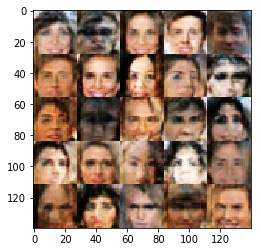

Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.3758  Iter: 2610
Epoch 1/1... Discriminator Loss: 1.6099... Generator Loss: 0.2988  Iter: 2620
Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0305  Iter: 2630
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 0.6817  Iter: 2640
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.5559  Iter: 2650
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 1.1307  Iter: 2660
Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.6361  Iter: 2670
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.3074  Iter: 2680
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.2194  Iter: 2690
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.7759  Iter: 2700


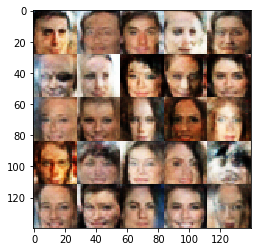

Epoch 1/1... Discriminator Loss: 0.9916... Generator Loss: 0.6550  Iter: 2710
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.4506  Iter: 2720
Epoch 1/1... Discriminator Loss: 0.7281... Generator Loss: 1.3242  Iter: 2730
Epoch 1/1... Discriminator Loss: 0.9193... Generator Loss: 0.8285  Iter: 2740
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.4494  Iter: 2750
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.3429  Iter: 2760
Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 0.9191  Iter: 2770
Epoch 1/1... Discriminator Loss: 1.1095... Generator Loss: 0.8349  Iter: 2780
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.8734  Iter: 2790
Epoch 1/1... Discriminator Loss: 1.9253... Generator Loss: 0.2221  Iter: 2800


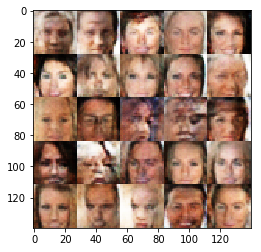

Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.2522  Iter: 2810
Epoch 1/1... Discriminator Loss: 1.2536... Generator Loss: 0.4285  Iter: 2820
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 0.6965  Iter: 2830
Epoch 1/1... Discriminator Loss: 0.9558... Generator Loss: 0.7808  Iter: 2840
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.5111  Iter: 2850
Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 0.6230  Iter: 2860
Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 1.6572  Iter: 2870
Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.6004  Iter: 2880
Epoch 1/1... Discriminator Loss: 0.9100... Generator Loss: 0.7829  Iter: 2890
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.4750  Iter: 2900


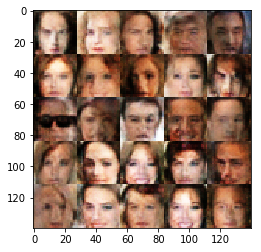

Epoch 1/1... Discriminator Loss: 1.0234... Generator Loss: 0.6187  Iter: 2910
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.4644  Iter: 2920
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 2.2931  Iter: 2930
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.4805  Iter: 2940
Epoch 1/1... Discriminator Loss: 0.8878... Generator Loss: 0.9253  Iter: 2950
Epoch 1/1... Discriminator Loss: 0.7361... Generator Loss: 1.0544  Iter: 2960
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 2.3622  Iter: 2970
Epoch 1/1... Discriminator Loss: 0.7862... Generator Loss: 0.8411  Iter: 2980
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 0.8970  Iter: 2990
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.3513  Iter: 3000


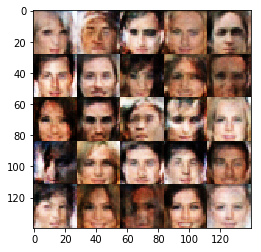

Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.0383  Iter: 3010
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.3746  Iter: 3020
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.4054  Iter: 3030
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.5419  Iter: 3040
Epoch 1/1... Discriminator Loss: 1.0190... Generator Loss: 1.4581  Iter: 3050
Epoch 1/1... Discriminator Loss: 0.9099... Generator Loss: 1.3423  Iter: 3060
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.4857  Iter: 3070
Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 0.9209  Iter: 3080
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 0.2332  Iter: 3090
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.7552  Iter: 3100


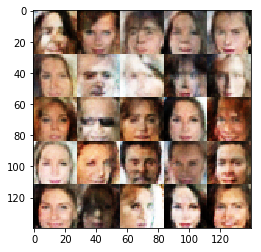

Epoch 1/1... Discriminator Loss: 0.7193... Generator Loss: 1.0294  Iter: 3110
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.9373  Iter: 3120
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 0.9051  Iter: 3130
Epoch 1/1... Discriminator Loss: 0.7715... Generator Loss: 0.8660  Iter: 3140
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.2940  Iter: 3150
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 0.5630  Iter: 3160
Epoch 1/1... Discriminator Loss: 0.6906... Generator Loss: 1.0162  Iter: 3170
Epoch 1/1... Discriminator Loss: 0.8303... Generator Loss: 0.9754  Iter: 3180
Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 0.6463  Iter: 3190
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.4055  Iter: 3200


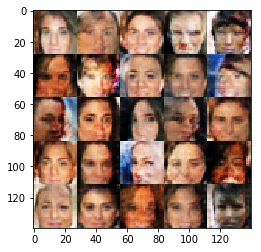

Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 0.9406  Iter: 3210
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.2926  Iter: 3220
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.4476  Iter: 3230
Epoch 1/1... Discriminator Loss: 1.1378... Generator Loss: 0.6133  Iter: 3240
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 0.9634  Iter: 3250
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.3893  Iter: 3260
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 0.9456  Iter: 3270
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.5963  Iter: 3280
Epoch 1/1... Discriminator Loss: 0.6644... Generator Loss: 1.1049  Iter: 3290
Epoch 1/1... Discriminator Loss: 1.5627... Generator Loss: 0.3187  Iter: 3300


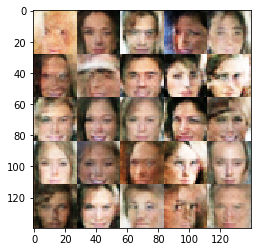

Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 2.4605  Iter: 3310
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.8584  Iter: 3320
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.6521  Iter: 3330
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 0.7585  Iter: 3340
Epoch 1/1... Discriminator Loss: 1.9861... Generator Loss: 0.1799  Iter: 3350
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.4309  Iter: 3360
Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.1397  Iter: 3370
Epoch 1/1... Discriminator Loss: 0.9433... Generator Loss: 0.9504  Iter: 3380
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.4476  Iter: 3390
Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.2921  Iter: 3400


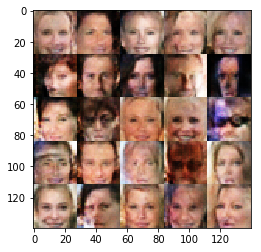

Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.3695  Iter: 3410
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.4684  Iter: 3420
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.4594  Iter: 3430
Epoch 1/1... Discriminator Loss: 0.7481... Generator Loss: 1.3472  Iter: 3440
Epoch 1/1... Discriminator Loss: 0.6589... Generator Loss: 1.0565  Iter: 3450
Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 0.7940  Iter: 3460
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.6773  Iter: 3470
Epoch 1/1... Discriminator Loss: 0.6139... Generator Loss: 1.9661  Iter: 3480
Epoch 1/1... Discriminator Loss: 0.9500... Generator Loss: 0.7462  Iter: 3490
Epoch 1/1... Discriminator Loss: 0.8095... Generator Loss: 0.8685  Iter: 3500


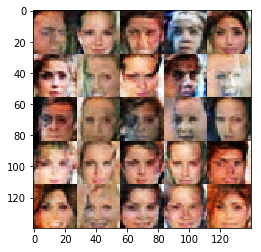

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.5793  Iter: 3510
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.4633  Iter: 3520
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.9934  Iter: 3530
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 2.1613  Iter: 3540
Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.7724  Iter: 3550
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 2.0433  Iter: 3560
Epoch 1/1... Discriminator Loss: 2.8448... Generator Loss: 0.1337  Iter: 3570
Epoch 1/1... Discriminator Loss: 0.8887... Generator Loss: 0.7676  Iter: 3580
Epoch 1/1... Discriminator Loss: 1.2014... Generator Loss: 0.8879  Iter: 3590
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.7369  Iter: 3600


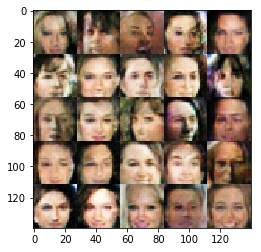

Epoch 1/1... Discriminator Loss: 0.8241... Generator Loss: 1.2729  Iter: 3610
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.7800  Iter: 3620
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.3354  Iter: 3630
Epoch 1/1... Discriminator Loss: 1.9246... Generator Loss: 0.1949  Iter: 3640
Epoch 1/1... Discriminator Loss: 0.7556... Generator Loss: 0.9506  Iter: 3650
Epoch 1/1... Discriminator Loss: 0.6608... Generator Loss: 1.2190  Iter: 3660
Epoch 1/1... Discriminator Loss: 0.7360... Generator Loss: 1.8905  Iter: 3670
Epoch 1/1... Discriminator Loss: 0.5673... Generator Loss: 1.5164  Iter: 3680
Epoch 1/1... Discriminator Loss: 0.5265... Generator Loss: 2.1990  Iter: 3690
Epoch 1/1... Discriminator Loss: 1.0324... Generator Loss: 0.6753  Iter: 3700


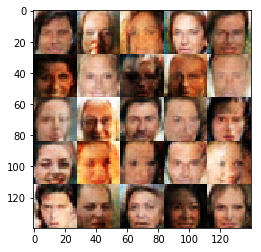

Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 0.6860  Iter: 3710
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 0.5685  Iter: 3720
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.6102  Iter: 3730
Epoch 1/1... Discriminator Loss: 0.8106... Generator Loss: 1.1149  Iter: 3740
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1014  Iter: 3750
Epoch 1/1... Discriminator Loss: 1.7258... Generator Loss: 0.2350  Iter: 3760
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.6965  Iter: 3770
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.2234  Iter: 3780
Epoch 1/1... Discriminator Loss: 1.6815... Generator Loss: 0.2628  Iter: 3790
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.5258  Iter: 3800


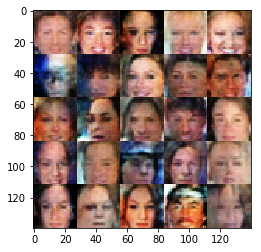

Epoch 1/1... Discriminator Loss: 0.9389... Generator Loss: 1.6483  Iter: 3810
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 0.6903  Iter: 3820
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.0964  Iter: 3830
Epoch 1/1... Discriminator Loss: 0.8989... Generator Loss: 0.7324  Iter: 3840
Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 0.7663  Iter: 3850
Epoch 1/1... Discriminator Loss: 1.8395... Generator Loss: 0.2065  Iter: 3860
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 2.6758  Iter: 3870
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.5590  Iter: 3880
Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.6948  Iter: 3890
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.3165  Iter: 3900


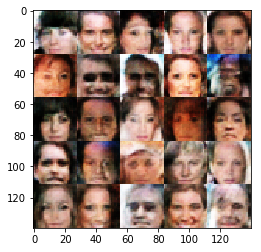

Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.0101  Iter: 3910
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.7367  Iter: 3920
Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 2.0749  Iter: 3930
Epoch 1/1... Discriminator Loss: 1.8933... Generator Loss: 0.2032  Iter: 3940
Epoch 1/1... Discriminator Loss: 1.9812... Generator Loss: 0.1813  Iter: 3950
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 1.3413  Iter: 3960
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 0.5984  Iter: 3970
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 2.5317  Iter: 3980
Epoch 1/1... Discriminator Loss: 1.7300... Generator Loss: 0.2784  Iter: 3990
Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 0.7507  Iter: 4000


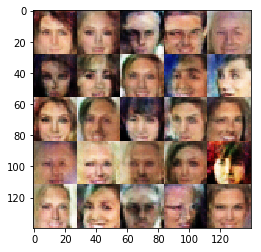

Epoch 1/1... Discriminator Loss: 0.6994... Generator Loss: 1.0956  Iter: 4010
Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 1.4800  Iter: 4020
Epoch 1/1... Discriminator Loss: 1.0032... Generator Loss: 0.9893  Iter: 4030
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.9898  Iter: 4040
Epoch 1/1... Discriminator Loss: 0.4483... Generator Loss: 1.7683  Iter: 4050
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 0.9046  Iter: 4060
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 0.8737  Iter: 4070
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.4495  Iter: 4080
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.4461  Iter: 4090
Epoch 1/1... Discriminator Loss: 0.7098... Generator Loss: 1.5444  Iter: 4100


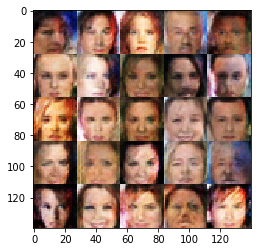

Epoch 1/1... Discriminator Loss: 1.7831... Generator Loss: 0.2978  Iter: 4110
Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 0.6738  Iter: 4120
Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 0.5623  Iter: 4130
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 0.9009  Iter: 4140
Epoch 1/1... Discriminator Loss: 1.5233... Generator Loss: 0.3302  Iter: 4150
Epoch 1/1... Discriminator Loss: 1.8614... Generator Loss: 0.2503  Iter: 4160
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.4050  Iter: 4170
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 1.2521  Iter: 4180
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.3484  Iter: 4190
Epoch 1/1... Discriminator Loss: 1.6352... Generator Loss: 0.2657  Iter: 4200


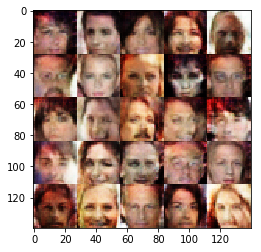

Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.5971  Iter: 4210
Epoch 1/1... Discriminator Loss: 0.9275... Generator Loss: 0.7063  Iter: 4220
Epoch 1/1... Discriminator Loss: 0.6288... Generator Loss: 1.0205  Iter: 4230
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.4144  Iter: 4240
Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.0980  Iter: 4250
Epoch 1/1... Discriminator Loss: 0.9255... Generator Loss: 1.6863  Iter: 4260
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 0.9037  Iter: 4270
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.5153  Iter: 4280
Epoch 1/1... Discriminator Loss: 0.7888... Generator Loss: 1.4286  Iter: 4290
Epoch 1/1... Discriminator Loss: 0.6508... Generator Loss: 1.0336  Iter: 4300


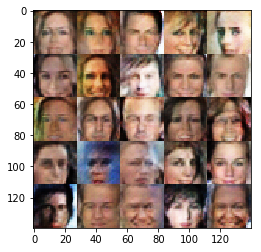

Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.3349  Iter: 4310
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.2911  Iter: 4320
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.3688  Iter: 4330
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.6810  Iter: 4340
Epoch 1/1... Discriminator Loss: 1.1478... Generator Loss: 2.6267  Iter: 4350
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 1.0579  Iter: 4360
Epoch 1/1... Discriminator Loss: 0.5398... Generator Loss: 3.0234  Iter: 4370
Epoch 1/1... Discriminator Loss: 0.7912... Generator Loss: 0.9666  Iter: 4380
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.8237  Iter: 4390
Epoch 1/1... Discriminator Loss: 0.8647... Generator Loss: 0.9268  Iter: 4400


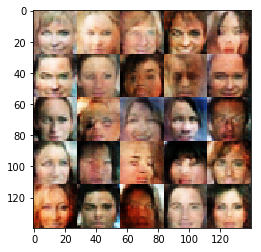

Epoch 1/1... Discriminator Loss: 0.8389... Generator Loss: 0.8347  Iter: 4410
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6465  Iter: 4420
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.2812  Iter: 4430
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.6121  Iter: 4440
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 2.0976  Iter: 4450
Epoch 1/1... Discriminator Loss: 0.7358... Generator Loss: 1.4313  Iter: 4460
Epoch 1/1... Discriminator Loss: 2.6863... Generator Loss: 0.1001  Iter: 4470
Epoch 1/1... Discriminator Loss: 0.9966... Generator Loss: 0.7166  Iter: 4480
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.4017  Iter: 4490
Epoch 1/1... Discriminator Loss: 0.4524... Generator Loss: 1.4546  Iter: 4500


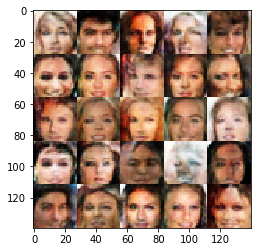

Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 0.8555  Iter: 4510
Epoch 1/1... Discriminator Loss: 1.8730... Generator Loss: 0.2420  Iter: 4520
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 1.1859  Iter: 4530
Epoch 1/1... Discriminator Loss: 0.9326... Generator Loss: 0.6623  Iter: 4540
Epoch 1/1... Discriminator Loss: 0.5943... Generator Loss: 1.4876  Iter: 4550
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 1.0063  Iter: 4560
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 0.6764  Iter: 4570
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5122  Iter: 4580
Epoch 1/1... Discriminator Loss: 0.9379... Generator Loss: 0.7149  Iter: 4590
Epoch 1/1... Discriminator Loss: 0.4832... Generator Loss: 1.3767  Iter: 4600


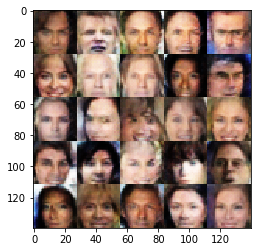

Epoch 1/1... Discriminator Loss: 0.5974... Generator Loss: 1.0580  Iter: 4610
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 1.3613  Iter: 4620
Epoch 1/1... Discriminator Loss: 1.7388... Generator Loss: 0.2481  Iter: 4630
Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.4160  Iter: 4640
Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 0.7183  Iter: 4650
Epoch 1/1... Discriminator Loss: 2.1789... Generator Loss: 0.1558  Iter: 4660
Epoch 1/1... Discriminator Loss: 1.2024... Generator Loss: 0.4899  Iter: 4670
Epoch 1/1... Discriminator Loss: 1.1672... Generator Loss: 0.6460  Iter: 4680
Epoch 1/1... Discriminator Loss: 1.5160... Generator Loss: 0.3277  Iter: 4690
Epoch 1/1... Discriminator Loss: 0.9655... Generator Loss: 1.1729  Iter: 4700


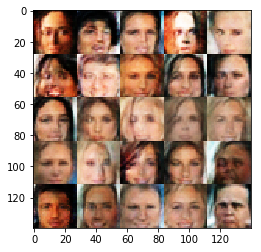

Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.6958  Iter: 4710
Epoch 1/1... Discriminator Loss: 0.7897... Generator Loss: 1.2068  Iter: 4720
Epoch 1/1... Discriminator Loss: 1.5406... Generator Loss: 0.3055  Iter: 4730
Epoch 1/1... Discriminator Loss: 0.6851... Generator Loss: 1.0253  Iter: 4740
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 1.7761  Iter: 4750
Epoch 1/1... Discriminator Loss: 0.7991... Generator Loss: 0.7716  Iter: 4760
Epoch 1/1... Discriminator Loss: 0.6918... Generator Loss: 1.5815  Iter: 4770
Epoch 1/1... Discriminator Loss: 0.8393... Generator Loss: 0.9412  Iter: 4780
Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 0.9132  Iter: 4790
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 1.1871  Iter: 4800


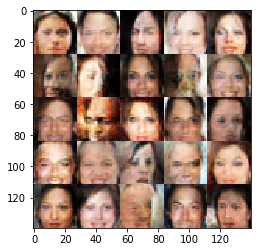

Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.0927  Iter: 4810
Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.4417  Iter: 4820
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 1.2206  Iter: 4830
Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 0.9903  Iter: 4840
Epoch 1/1... Discriminator Loss: 1.5560... Generator Loss: 0.3252  Iter: 4850
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.5048  Iter: 4860
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.4640  Iter: 4870
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 0.8462  Iter: 4880
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.4274  Iter: 4890
Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 0.9854  Iter: 4900


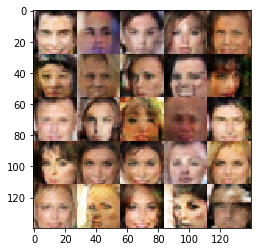

Epoch 1/1... Discriminator Loss: 1.6063... Generator Loss: 0.3256  Iter: 4910
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.5120  Iter: 4920
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5232  Iter: 4930
Epoch 1/1... Discriminator Loss: 0.2992... Generator Loss: 1.9840  Iter: 4940
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.0440  Iter: 4950
Epoch 1/1... Discriminator Loss: 1.5318... Generator Loss: 0.2999  Iter: 4960
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.2850  Iter: 4970
Epoch 1/1... Discriminator Loss: 1.0396... Generator Loss: 0.6277  Iter: 4980
Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 0.6570  Iter: 4990
Epoch 1/1... Discriminator Loss: 0.7961... Generator Loss: 1.0188  Iter: 5000


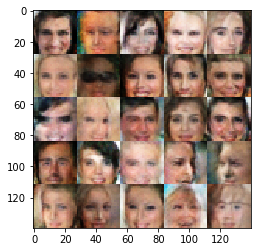

Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 0.9736  Iter: 5010
Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.8726  Iter: 5020
Epoch 1/1... Discriminator Loss: 0.8094... Generator Loss: 1.0093  Iter: 5030
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.0927  Iter: 5040
Epoch 1/1... Discriminator Loss: 1.8720... Generator Loss: 0.2255  Iter: 5050
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.3399  Iter: 5060
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 0.6647  Iter: 5070
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 1.7350  Iter: 5080
Epoch 1/1... Discriminator Loss: 0.9222... Generator Loss: 1.5854  Iter: 5090
Epoch 1/1... Discriminator Loss: 1.2747... Generator Loss: 0.5893  Iter: 5100


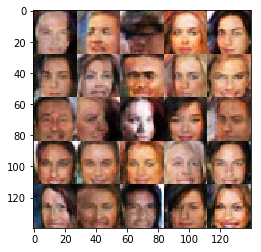

Epoch 1/1... Discriminator Loss: 1.5441... Generator Loss: 0.3129  Iter: 5110
Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 0.7263  Iter: 5120
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 0.8869  Iter: 5130
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 0.6916  Iter: 5140
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.4397  Iter: 5150
Epoch 1/1... Discriminator Loss: 2.4993... Generator Loss: 0.0988  Iter: 5160
Epoch 1/1... Discriminator Loss: 0.9244... Generator Loss: 1.0799  Iter: 5170
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 0.6253  Iter: 5180
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 0.8019  Iter: 5190
Epoch 1/1... Discriminator Loss: 0.5460... Generator Loss: 1.7293  Iter: 5200


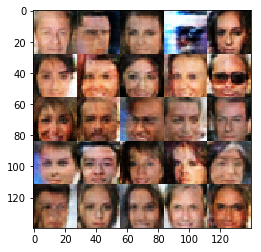

Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 0.9492  Iter: 5210
Epoch 1/1... Discriminator Loss: 0.7786... Generator Loss: 3.1438  Iter: 5220
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.5264  Iter: 5230
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.2921  Iter: 5240
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.1014  Iter: 5250
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.3887  Iter: 5260
Epoch 1/1... Discriminator Loss: 0.3948... Generator Loss: 2.3223  Iter: 5270
Epoch 1/1... Discriminator Loss: 1.2079... Generator Loss: 0.4857  Iter: 5280
Epoch 1/1... Discriminator Loss: 1.9107... Generator Loss: 0.2143  Iter: 5290
Epoch 1/1... Discriminator Loss: 0.6238... Generator Loss: 1.2369  Iter: 5300


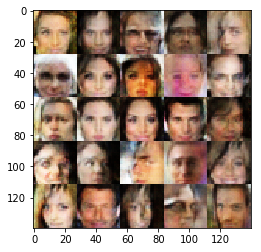

Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 0.9519  Iter: 5310
Epoch 1/1... Discriminator Loss: 0.6965... Generator Loss: 1.2281  Iter: 5320
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.4443  Iter: 5330
Epoch 1/1... Discriminator Loss: 0.8410... Generator Loss: 1.2162  Iter: 5340
Epoch 1/1... Discriminator Loss: 0.6515... Generator Loss: 1.2516  Iter: 5350
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.3948  Iter: 5360
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 0.7479  Iter: 5370
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.7359  Iter: 5380
Epoch 1/1... Discriminator Loss: 0.5105... Generator Loss: 1.8619  Iter: 5390
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 3.1627  Iter: 5400


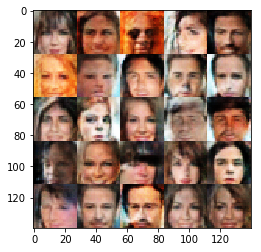

Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.4360  Iter: 5410
Epoch 1/1... Discriminator Loss: 1.5159... Generator Loss: 0.3384  Iter: 5420
Epoch 1/1... Discriminator Loss: 2.6073... Generator Loss: 0.1232  Iter: 5430
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.5421  Iter: 5440
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.5174  Iter: 5450
Epoch 1/1... Discriminator Loss: 1.0885... Generator Loss: 0.6696  Iter: 5460
Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.4405  Iter: 5470
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.6831  Iter: 5480
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 0.5431  Iter: 5490
Epoch 1/1... Discriminator Loss: 1.9067... Generator Loss: 0.2116  Iter: 5500


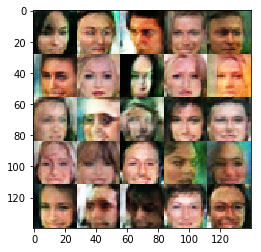

Epoch 1/1... Discriminator Loss: 0.7427... Generator Loss: 1.3986  Iter: 5510
Epoch 1/1... Discriminator Loss: 0.8809... Generator Loss: 0.9465  Iter: 5520
Epoch 1/1... Discriminator Loss: 2.7545... Generator Loss: 0.0910  Iter: 5530
Epoch 1/1... Discriminator Loss: 1.1930... Generator Loss: 0.4995  Iter: 5540
Epoch 1/1... Discriminator Loss: 1.4929... Generator Loss: 0.3565  Iter: 5550
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.4102  Iter: 5560
Epoch 1/1... Discriminator Loss: 1.0150... Generator Loss: 0.7447  Iter: 5570
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.4853  Iter: 5580
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 1.8646  Iter: 5590
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 0.5507  Iter: 5600


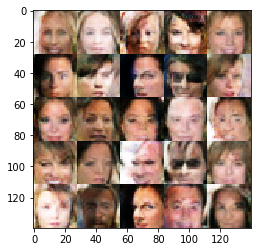

Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.0277  Iter: 5610
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.3506  Iter: 5620
Epoch 1/1... Discriminator Loss: 2.0493... Generator Loss: 0.1893  Iter: 5630
Epoch 1/1... Discriminator Loss: 0.8540... Generator Loss: 1.3997  Iter: 5640
Epoch 1/1... Discriminator Loss: 1.5600... Generator Loss: 0.4233  Iter: 5650
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 1.4118  Iter: 5660
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.7875  Iter: 5670
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.7584  Iter: 5680
Epoch 1/1... Discriminator Loss: 0.8513... Generator Loss: 1.1614  Iter: 5690
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.2137  Iter: 5700


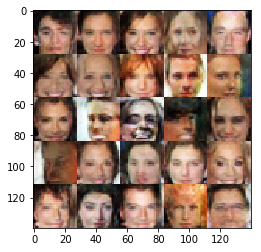

Epoch 1/1... Discriminator Loss: 0.9051... Generator Loss: 0.8443  Iter: 5710
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.3502  Iter: 5720
Epoch 1/1... Discriminator Loss: 0.7230... Generator Loss: 0.8861  Iter: 5730
Epoch 1/1... Discriminator Loss: 0.8018... Generator Loss: 1.4395  Iter: 5740
Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.8228  Iter: 5750
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.8073  Iter: 5760
Epoch 1/1... Discriminator Loss: 0.4928... Generator Loss: 1.4437  Iter: 5770
Epoch 1/1... Discriminator Loss: 0.9789... Generator Loss: 0.6527  Iter: 5780
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.4110  Iter: 5790
Epoch 1/1... Discriminator Loss: 0.7066... Generator Loss: 1.8590  Iter: 5800


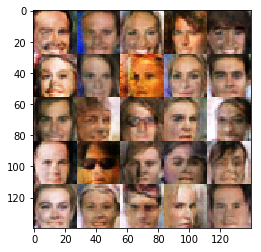

Epoch 1/1... Discriminator Loss: 0.8190... Generator Loss: 1.2031  Iter: 5810
Epoch 1/1... Discriminator Loss: 0.8850... Generator Loss: 1.8169  Iter: 5820
Epoch 1/1... Discriminator Loss: 1.0575... Generator Loss: 0.6194  Iter: 5830
Epoch 1/1... Discriminator Loss: 0.1771... Generator Loss: 3.0304  Iter: 5840
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.5352  Iter: 5850
Epoch 1/1... Discriminator Loss: 2.1267... Generator Loss: 0.1705  Iter: 5860
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.4023  Iter: 5870
Epoch 1/1... Discriminator Loss: 0.5477... Generator Loss: 1.4343  Iter: 5880
Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.0977  Iter: 5890
Epoch 1/1... Discriminator Loss: 0.6426... Generator Loss: 1.1706  Iter: 5900


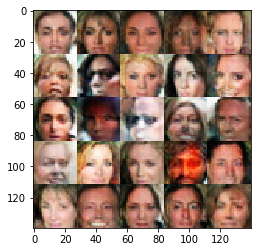

Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.0266  Iter: 5910
Epoch 1/1... Discriminator Loss: 1.6090... Generator Loss: 0.3825  Iter: 5920
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 0.8203  Iter: 5930
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.5977  Iter: 5940
Epoch 1/1... Discriminator Loss: 0.5418... Generator Loss: 1.2934  Iter: 5950
Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 1.2881  Iter: 5960
Epoch 1/1... Discriminator Loss: 2.0675... Generator Loss: 0.2055  Iter: 5970
Epoch 1/1... Discriminator Loss: 1.8499... Generator Loss: 0.2392  Iter: 5980
Epoch 1/1... Discriminator Loss: 0.8839... Generator Loss: 0.8478  Iter: 5990
Epoch 1/1... Discriminator Loss: 1.0236... Generator Loss: 0.6797  Iter: 6000


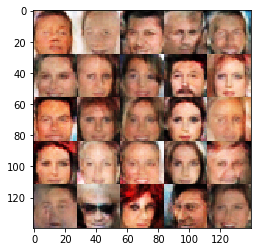

Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 0.6897  Iter: 6010
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.3312  Iter: 6020
Epoch 1/1... Discriminator Loss: 2.3033... Generator Loss: 0.1491  Iter: 6030
Epoch 1/1... Discriminator Loss: 2.8110... Generator Loss: 0.0846  Iter: 6040
Epoch 1/1... Discriminator Loss: 0.8300... Generator Loss: 0.9313  Iter: 6050
Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.7487  Iter: 6060
Epoch 1/1... Discriminator Loss: 0.6306... Generator Loss: 1.1129  Iter: 6070
Epoch 1/1... Discriminator Loss: 0.6722... Generator Loss: 1.1189  Iter: 6080
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 2.8870  Iter: 6090
Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.9802  Iter: 6100


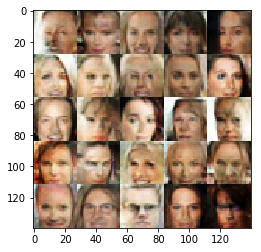

Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.4807  Iter: 6110
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.8859  Iter: 6120
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 0.7573  Iter: 6130
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 1.8526  Iter: 6140
Epoch 1/1... Discriminator Loss: 1.4833... Generator Loss: 0.3609  Iter: 6150
Epoch 1/1... Discriminator Loss: 1.4938... Generator Loss: 0.3431  Iter: 6160
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.3937  Iter: 6170
Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.1403  Iter: 6180
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.4782  Iter: 6190
Epoch 1/1... Discriminator Loss: 0.8355... Generator Loss: 0.8069  Iter: 6200


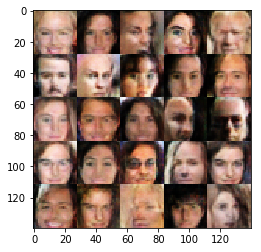

Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 1.2764  Iter: 6210
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 0.3261  Iter: 6220
Epoch 1/1... Discriminator Loss: 2.0578... Generator Loss: 0.1718  Iter: 6230
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 2.8767  Iter: 6240
Epoch 1/1... Discriminator Loss: 0.4536... Generator Loss: 1.6408  Iter: 6250
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.5103  Iter: 6260
Epoch 1/1... Discriminator Loss: 0.3211... Generator Loss: 2.0519  Iter: 6270
Epoch 1/1... Discriminator Loss: 1.7305... Generator Loss: 0.2228  Iter: 6280
Epoch 1/1... Discriminator Loss: 0.6944... Generator Loss: 1.3021  Iter: 6290
Epoch 1/1... Discriminator Loss: 0.7703... Generator Loss: 1.0355  Iter: 6300


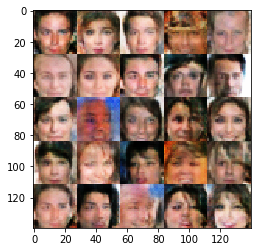

Epoch 1/1... Discriminator Loss: 0.9302... Generator Loss: 1.4112  Iter: 6310
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.4302  Iter: 6320
Epoch 1/1... Discriminator Loss: 2.5141... Generator Loss: 0.1210  Iter: 6330


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.